# Problema 1

**Grupo 8**<br>
- Anabela Pereira - A87990
- André Gonçalves - A87942

In [37]:
from z3 import *
import networkx as nx
from pyscipopt import Model,quicksum,quickprod
import random as r

## a.  
### i.
cria_grafo é uma função que cria um grafo ligado em que os nós estão ligados aleatóriamente. Esta função recebe um dicionário com $0..N-1$ chaves, que representam os vértices, e faz corresponder a cada chave um número entre $1..d$, $d \leq N-1$.

Algoritmo:
A função tem uma lista, nodos, dos vértices que ainda não estão no grafo.
1. A função escolhe 2 vértices aleatórios v1 e v2 e acrescenta ao grafo os arcos (v1,v2) e (v2,v1). v1 e v2 são retirados de nodos.
2. Inicia-se um ciclo até que nodos = \[\].
    1. Escolhe-se um nodo, v, ao caso de nodos. Existem duas possibilidades:
        1. é escolhido ao acaso um vértice v1, se v1 tem um arco de saída disponível são acrescentados aos grafos os vértices (v1,v) e (v,v2) caso contrário é feita a segunda possibelidade;  
        2. v é acrescentado entre um arco, ou seja, é escolhido um arco, (v1,v2), aleatóriamente. O arco (v1,v2) é removido do grafo e acrescentam-se os arcos (v1,v) e (v,v2).
3. O grafo é ligado e possuí todos os vértices mas ainda é possível acrescentar mais arcos por isso são escolhidos aleatóriamente até que f={} (sempre que f\[v\]=0, v é removido de f).



In [38]:
def cria_grafo(f):# f é um dicionario que faz corresponder a cada vertice do grafo o numero de nodos que liga de 1 a d
    
    G = nx.DiGraph()
    nodos = list(f)
    
    v1 = r.choice(nodos)
    nodos.remove(v1)
    v2 = r.choice(nodos)
    nodos.remove(v2)
    
    G.add_edge(v1,v2)
    G.add_edge(v2,v1)
    
    f[v1]-=1
    f[v2]-=1
      
    if f[v1]==0:
        f.pop(v1)
    if f[v2]==0:
        f.pop(v2)  
    
    while nodos!=[]:
        
        v = r.choice(nodos)
        nodos.remove(v)
        
        v1 = r.choice(list(G.nodes()))
        v2 = r.choice(list(G.nodes()))
        
        opt = r.choice((True,False))
        
        if (opt):
            if v1 in f:
                G.add_edge(v1,v)
                G.add_edge(v,v2)
                
                f[v1]-=1
                if f[v1]==0:
                    f.pop(v1)
            else:
                opt = False
        
        if (not opt):
            v2 = r.choice(list(G.successors(v1)))
            G.remove_edge(v1,v2)
            G.add_edge(v1,v)
            G.add_edge(v,v2)
            
        f[v]-=1
        if f[v]==0:
            f.pop(v)
        
    while f!={}:
        v = r.choice(list(f))
        v1=v
        while v==v1 or G.has_edge(v,v1):
            v1 = r.choice(list(G.nodes()))
        G.add_edge(v,v1)
        f[v]-=1
        if f[v]==0:
            f.pop(v)

    return G

{0: 1, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 2, 12: 2, 13: 2, 14: 1, 15: 2, 16: 2, 17: 2, 18: 1, 19: 1, 20: 2, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 2, 31: 1}


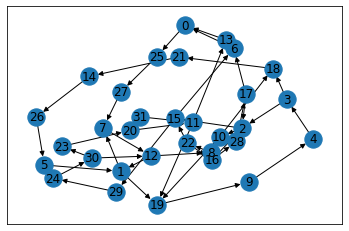

In [47]:
N = 32
d = 2
f = {}

for i in range(N):
        f[i] = r.randrange(1,d+1)

print(f)

G = cria_grafo(f)
nx.draw_networkx(G)

In [48]:
def ligado(G):
    b = True
    for i in G.nodes():
        b = b and nx.has_path(G,0,i)
    return b

assert ligado(G) == True

## b.

Seja $G$ um grafo orientado ligado $(V,E)$.
Temos um dicionário $x$ para representar as arestas.
Temos também um dicionário $f$ que faz corresponder a cada nodo um valor aleatório de $1..d$.

Caso exista uma aresta $e$ então $x_e = 1$ se não $x_e=0$:

$$
\forall e \in E \quad x_e>=0, x_e<=1
$$

#### Condições

1. Para todo o edge $e$ se $e$ não pertence aos edges do grafo então $x_e$ = 0

$$
\forall e \notin E \cdot \quad x_e = 0
$$

2. O grafo é ligada, ou seja, para qualquer vértice $v_1$ existe um caminho para qualquer vértice $v_2$.

$$
\forall v1,v2 \in E \cdot \quad \exists p[v1,v2]
$$

Consideremos P o conjunto dos caminhos $P_{v1,v2}$ são os caminhos que existem no grafo de $v_1$ para $v_2$.

$$
\forall v1,v2 \in E \cdot \quad \sum_{p \in P[v1,v2]} \prod_{u_1,...,u_n \in p} x_{u_{i},u_{i+1}} \geq 1
$$


Optimização

3. Se existe apenas um caminho ($v_1$,...,$v_n$) então as arestas ($v_1$,$v_2$) ... ($v_{n-1}$,$v_n$) pertencem ao grafo.

$$
\forall p = (v_1,...,v_n) \in P \cdot \quad |p| = 1 \implies x_{v_1,v_2}=1 ... x_{v_{n-1},v_n}=1
$$

- Maximizar o número de vias que é possível remover mantendo o grafo ligado, ou seja, minimizar o número de arestas.

$$
\sum_{e \in E} x_e
$$
 

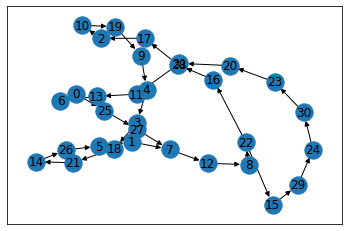

In [49]:
def retirar_caminhos(G):
    
    model = Model("LC")
    x = {}
    V = range(len(list(G.nodes())))
    E = list(G.edges())
    
    for e in E:
        x[e] = model.addVar(vtype="I", name=str(e))
        model.addCons(x[e]>=-1)
        model.addCons(1>=x[e])
    
    P = {} # paths
    for v1 in V:
        for v2 in V:
            if v1!=v2:
                P[v1,v2]= list( nx.all_simple_paths(G,v1,v2))
                # 3
                if len(P[v1,v2])==1:
                    p=P[v1,v2][0]
                    for i in range(len(p)-1):
                        model.addCons(x[(p[i],p[i+1])]==1)
                            
                # 2
                else:
                    model.addCons(quicksum(quickprod(x[(p[i],p[i+1])] for i in range(len(p)-1)) for p in P[v1,v2])>=1)
    
        
    model.setObjective(quicksum(list(x.values())), "minimize")   
    
    model.hideOutput()
    model.optimize()
    
    G_res = nx.DiGraph()
    
    for v1,v2 in x:
        if model.getVal(x[v1,v2]) == 1:
            G_res.add_edge(v1,v2)
    
    return G_res
            
G_ = retirar_caminhos(G)
nx.draw_networkx(G_)

In [50]:
assert ligado(G_) == True

### Outra tentativa

Esta função só funciona quando existe um ciclo que passa por todos os pontos e para um N baixo.

Caso exista uma aresta $e$ então $x_e = 1$ se não $x_e=0$:

$$
\forall e \in E \quad x_e>=0, x_e<=1
$$

Se não existe um caminho v1,v2 então x_{v1,v2}=0

$$
\forall e \notin E \cdot \quad x_e = 0
$$

1. Para qualquer vértice v existe pelo menos um caminho a passar por v e outro a sair de v. 
$$
\forall v1 \in V \cdot \quad \sum_{v2 \in V} x_{v1,v2} \geq 1
$$

$$
\forall v1 \in V \cdot \quad \sum_{v2 \in V} x_{v2,v1} \geq 1
$$

2. Existe um caminho entre todos os vértices.
    Temos a função partes que calcula P(N).

$$
\forall g \in \wp(G) \cdot \quad \sum_{v1 \in g} \sum_{v2 \in g} x_{v1,v2} \leq |g| - 1
$$

- Minimizar o número de arestas.

$$
\sum_{e \in E} x_e
$$

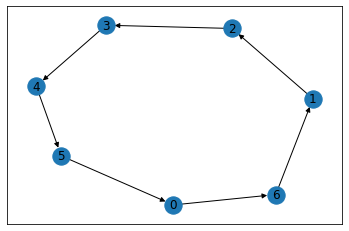

In [36]:
def partes (N):
    l=[]
    for i in range(1,2**N):
        y=[]
        k=i
        for j in range(N):
            y.append(k%2)            
            k//=2
        l.append(y)
    r=[]

    for i in l:
        j=[]
        for x,y in zip(i,range(N)):
            if x==1:
                j.append(y)
        r.append(j)
    return r


def retirar_caminhos(G):
    
    s = Optimize()
    x = {}
    V = len(list(G.nodes()))
    E = list(G.edges())
    c = {}
    for v1 in range(V):
        for v2 in range(V):
            x[v1,v2] = Int(str((v1,v2)))
            s.add(x[v1,v2]>=0)
            s.add(x[v1,v2]<=1)
            if (v1,v2) not in E:
                s.add(c[v1,v2]==0)
                s.add(x[v1,v2]==0)
            

    
    for v1 in range(V):
        s.add(Sum([x[v1,v2] for v2 in range(V)])>=1)
        s.add(Sum([x[v2,v1] for v2 in range(V)])>=1)
        
        
    for i in partes(V):
        if len(i)>=2 and len(i)<=V-1:
            s.add(Sum([Sum([x[v1,v2] for v2 in i]) for v1 in i])<=len(i)-1)
        
    s.minimize(Sum([x[v1,v2] for v1 in range(V) for v2 in range(V)]))   

    G_res = nx.DiGraph()
    
    if s.check() == sat:
        m =s.model()
        for v1 in range(V):
            for v2 in range(V):
                if m[x[v1,v2]]==1:
                    if (v1,v2) not in E:
                        print("Erro:",v1,v2)
                    G_res.add_edge(v1,v2)
        
    return G_res

G_ = retirar_caminhos(G)
nx.draw_networkx(G_)